In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# from linearmodels.panel.data import PanelData
# from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
import pyblp
import sys
import datetime
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# def mute():
#     sys.stdout = open('nul', 'w')
#     # a=0
# def unmute():
#     sys.stdout = sys.__stdout__

drop_self,drop_nonself=0,0
if len(sys.argv) > 2:
    drop_self = int(sys.argv[1])
    drop_nonself = int(sys.argv[2])
    print(f"Received parameters: param1={drop_self}, param2={drop_nonself}")
else:
    print("Insufficient parameters. Please provide two parameters.")
# Call the function with suppressed output
# mute()
save=0

product_data=pd.read_csv("../../data/merged/len3_ndb_blp_DN_firm_FC.csv",encoding="utf-8",index_col=0)
print(product_data.columns[:30])
# rename
product_data=product_data.rename(columns={"薬価":"prices",
                    "同一剤形・規格の後発医薬品がある先発医薬品":"long_term",
                    "医薬品名":"product_ids",
                    "薬効分類":"TClass",
                    "メーカー名":"firm_ids"})

product_data["long_term"] = product_data["long_term"].replace("○", 1).fillna(0)
product_data.loc[product_data["firm_ids"]=="self","prices"]=product_data.loc[product_data["firm_ids"]=="self","mean_price"]*0.5
product_data.loc[product_data["firm_ids"]=="nonself","prices"]=product_data.loc[product_data["firm_ids"]=="nonself","mean_price"]*0.5*0.7
product_data = product_data[product_data["year"] > 2014]
product_data.loc[:,"market_ids"]=product_data.loc[:,"TClass"].astype(int).astype(str)+"-"+product_data.loc[:,"year"].astype(int).astype(str)
product_data.loc[:,"shares"]=product_data["総計"]/(120000000*100)
if drop_nonself:
    product_data = product_data[product_data["firm_ids"]!="nonself"]
if drop_self:
    product_data = product_data[product_data["firm_ids"]!="self"]

product_data["prices"]=product_data["prices"]*3.4
# unmute()
# # otcのシェア
# # print(product_data.loc[product_data["firm_ids"].isin(["self","nonself"]),"shares"].sum()/product_data["shares"].sum())
# mute()
# drop which doesn't have generic
# product_data=product_data[~((product_data["long_term"]==0)&(product_data["generic"]==0))]
product_data=product_data.loc[product_data["shares"]>0]
# unmute()
# print(product_data.loc[product_data["markup"].isna(),["product_ids","firm_ids","prices","markup","year"]])
# print(set(product_data.loc[product_data["markup"].isna(),"year"]))
# mute()
product_data=product_data[["wholesale_price","markup","product_ids","market_ids","firm_ids","prices","brand","oral","generic","in_hospital","TClass","year","shares","id_l4","long_term","otc","Pharmacopoeia"]]
product_data=product_data.astype({"prices":float,"shares":float,"oral":float,"generic":int,"otc":int,"in_hospital":int,"long_term":int})
product_data.reset_index(drop=True,inplace=True)
# unmute()
# # print(product_data.corr())
# # print(product_data.corr()>0.1)
# mute()
# specify instruments
demand_instruments=pyblp.build_blp_instruments(pyblp.Formulation("1+generic+in_hospital+oral+long_term+Pharmacopoeia"),product_data=product_data)
# demand_instruments=pyblp.build_blp_instruments(formulation=pyblp.Formulation("1+prices+generic+oral+in_hospital"),product_data=product_data)

MD=demand_instruments.shape[1]
demand_instruments=pd.DataFrame(demand_instruments, columns=[f'demand_instruments{i}' for i in range(MD)])
product_data=pd.concat([product_data,demand_instruments],axis=1)
# unmute()
# print(product_data.corr().to_csv('correlation_matrix.csv', sep='\t'))
# print(product_data.corr()>0.1)
# mute()
# lagged demand instruments
# demand_instrument_columns = [col for col in product_data.columns if col.startswith('demand_instrument')]
# def lag_demand_instruments(group):
#     for col in demand_instrument_columns:
#         for i in range(N_DI):  # 0から1までのラグを取得
#             lagged_column_name = f'demand_instruments{i+N_DI}'
#             group[lagged_column_name] = group[col].shift(1)
#     return group
# product_data=product_data.sort_values(['TClass', 'year'])
# product_data = product_data.groupby('id_l4').apply(lag_demand_instruments)
# product_data.shape

product_data.loc[product_data["product_ids"]=="self"]["shares"]
# nesting
product_data["nesting_ids"]=product_data["generic"].astype(str)+product_data["otc"].astype(str)
logit_formulation= pyblp.Formulation('prices+in_hospital+oral+generic+otc+long_term+Pharmacopoeia', absorb='C(TClass)+C(year)+C(firm_ids)')
if drop_self and drop_nonself:
    logit_formulation= pyblp.Formulation('prices+in_hospital+oral+generic+long_term+Pharmacopoeia', absorb='C(TClass)+C(year)+C(firm_ids)')
# logit_formulation= pyblp.Formulation('prices+oral+in_hospital+long_term', absorb='C(market_ids)+C(firm_ids)')

# typeで怒られがち
problem = pyblp.Problem(product_formulations=logit_formulation, product_data=product_data)
# problem
optimization=pyblp.Optimization('l-bfgs-b')
logit_results = problem.solve(rho=0.7, optimization=optimization,rho_bounds=(0,1))

# unmute()
print(logit_results)
# mute()

# print(np.round(logit_results.beta.T/(1-logit_results.rho),4))
# print(np.round(logit_results.beta_se.T,6))
data = np.vstack((logit_results.beta.T/(1-logit_results.rho),
logit_results.beta_se.T))

# Find the maximum width for each column
max_widths = [max(len(f"{num:.4f}") for num in col) for col in zip(*data)]

# Format and print the aligned data
for row in data:
    formatted_row = [f"{num:.4f}".rjust(max_width) for num, max_width in zip(row, max_widths)]
    print(" ".join(formatted_row))
instruments_results=logit_results.compute_optimal_instruments()
instruments_results
updated_problem=instruments_results.to_problem()
updated_results=updated_problem.solve(rho=0.7,optimization=optimization,rho_bounds=(0,1))
# unmute()
print(updated_results)
# mute()
print(np.round(updated_results.beta.T/(1-updated_results.rho),4))
costs = updated_results.compute_costs()
# plt.hist(costs, bins=50)
# plt.legend(["Marginal Costs"])
# plt.show()
markups = updated_results.compute_markups(costs=costs)
# plt.hist(markups, bins=50)
# plt.legend(["Markups"])
cs=logit_results.compute_consumer_surpluses()
cs2=logit_results.compute_consumer_surpluses(eliminate_product_ids=["self"])
cs3=logit_results.compute_consumer_surpluses(eliminate_product_ids=["nonself"])
cs4=logit_results.compute_consumer_surpluses(eliminate_product_ids=["nonself","self"])
# unmute()
print("logit")
print([np.mean(cs),np.mean(cs2),np.mean(cs3),np.mean(cs4)]/np.mean(cs))
print(sum(cs),sum(cs2),sum(cs3),sum(cs4))
# mute()
cs=updated_results.compute_consumer_surpluses()
cs2=updated_results.compute_consumer_surpluses(eliminate_product_ids=["self"])
cs3=updated_results.compute_consumer_surpluses(eliminate_product_ids=["nonself"])
cs4=updated_results.compute_consumer_surpluses(eliminate_product_ids=["nonself","self"])
# unmute()
print("updated") 
print([np.mean(cs),np.mean(cs2),np.mean(cs3),np.mean(cs4)]/np.mean(cs))
print(sum(cs),sum(cs2),sum(cs3),sum(cs4))
print("delta",np.mean(logit_results.delta),np.sum(logit_results.delta))
print("optimal delta",np.mean(updated_results.delta),"drop_self",drop_self,"drop_nonself",drop_nonself)
# mute()

# Get the current date and time
current_time = datetime.datetime.now()

# Format the time as a string
time_string = current_time.strftime("%Y-%m-%d_%H-%M-%S")
if save:
    logit_results.to_pickle(f"./results/NL_len3_{time_string}_{drop_self}{drop_nonself}.pkl")



In [22]:
# unmute()
cs=logit_results.compute_consumer_surpluses()
cs2=logit_results.compute_consumer_surpluses(eliminate_product_ids=["self"])
cs3=logit_results.compute_consumer_surpluses(eliminate_product_ids=["nonself"])
cs4=logit_results.compute_consumer_surpluses(eliminate_product_ids=["nonself","self"])
print("logit")
print([np.mean(cs),np.mean(cs2),np.mean(cs3),np.mean(cs4)]/np.mean(cs))
sum(cs),sum(cs2),sum(cs3),sum(cs4)
sum(cs)/7,sum(cs2)/7,sum(cs3)/7,sum(cs4)/7



(array([77994.93846267]),
 array([76753.63111249]),
 array([75215.49733687]),
 array([73930.74756725]))

In [15]:
elasticities = logit_results.compute_elasticities()
# %matplotlib inline
import matplotlib.pyplot as plt
single_market = product_data['market_ids'] == '131-2015'
K=sum(single_market)
# plt.colorbar(plt.matshow(elasticities[single_market][:,:K]))
product_data[single_market].shape,K
elasticities[single_market][:,:K]
diversions = logit_results.compute_diversion_ratios()


In [16]:

(logit_results.problem.products["firm_ids"]=="self").shape
self_m=np.array(pd.DataFrame(elasticities).loc[logit_results.problem.products["firm_ids"]=="self"].mean(axis=1))
nonself_m=np.array(pd.DataFrame(elasticities).loc[logit_results.problem.products["firm_ids"]=="nonself"].mean(axis=1))
other_m = np.array(pd.DataFrame(elasticities).loc[~np.isin(logit_results.problem.products["firm_ids"], ["self", "nonself"])].mean(axis=1))
len(self_m),len(nonself_m),len(other_m) 
np.mean(self_m),np.mean(nonself_m),np.mean(other_m)
np.std(self_m),np.std(nonself_m),np.std(other_m)

(0.00022203724491606244, 0.0004970533001789853, 0.007509073991519506)

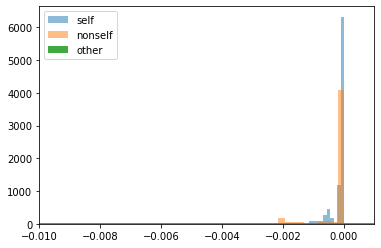

In [17]:
plt.hist(self_m,density=True,alpha=0.5)
plt.hist(nonself_m,density=True,alpha=0.5)
plt.hist(other_m,density=True,alpha=0.9)
plt.legend(["self","nonself","other"])
plt.xlim(-1e-2,1e-3)
plt.show()

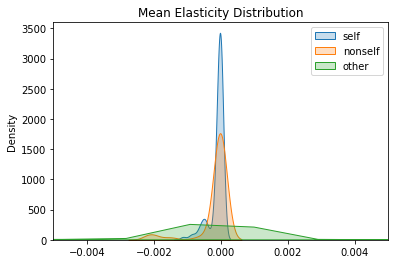

In [18]:
import seaborn as sns
def x_weights(data):
    x_weights = np.ones_like(data) / len(data)
    return x_weights
sns.kdeplot(x=self_m, label='self',fill=True,weights=x_weights(self_m))
sns.kdeplot(x=nonself_m, label='nonself',fill=True,weights=x_weights(nonself_m))
sns.kdeplot(x=other_m, label='other',fill=True,weights=x_weights(other_m))
plt.title('Mean Elasticity Distribution')
plt.legend()
plt.xlim(-.5e-2,.5e-2)
plt.show()

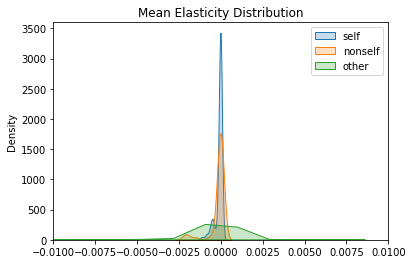

In [19]:
import seaborn as sns
def x_weights(data):
    x_weights = np.ones_like(data) / len(data)
    return x_weights
sns.kdeplot(x=self_m, label='self',fill=True)
sns.kdeplot(x=nonself_m, label='nonself',fill=True)
sns.kdeplot(x=other_m, label='other',fill=True)
plt.title('Mean Elasticity Distribution')
plt.legend()
plt.xlim(-1e-2,1e-2)
plt.show()